In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import timeit
import h5py
from pathlib import Path
import numpy as np
from itertools import product
import pickle
import scipy.special
import scipy.stats
from math import exp
import multiprocessing
import functools

from montecarlo import DataLogger

%matplotlib inline
np.seterr(all='warn')
textwidth = 6.268
mpl.rcParams['figure.dpi'] = 70
default_figargs = dict(figsize = (textwidth,textwidth))

from montecarlo import *

In [6]:
n_cumulants = 5
T = np.linspace(0.01, 10, 20)
beta = 1/T
Ns = [8,16]
#Us = [0.1,1,10]
Us = [10]
Js = np.linspace(0, 10, 20)
binder_params = dict(t = 1, alpha = 1.5, mu = 0, normalise = True)
N_steps = int(40 * 1000)
N_burn_in = int(5 * 1000)
print(T, Js)

[ 0.01        0.53578947  1.06157895  1.58736842  2.11315789  2.63894737
  3.16473684  3.69052632  4.21631579  4.74210526  5.26789474  5.79368421
  6.31947368  6.84526316  7.37105263  7.89684211  8.42263158  8.94842105
  9.47421053 10.        ] [ 0.          0.52631579  1.05263158  1.57894737  2.10526316  2.63157895
  3.15789474  3.68421053  4.21052632  4.73684211  5.26315789  5.78947368
  6.31578947  6.84210526  7.36842105  7.89473684  8.42105263  8.94736842
  9.47368421 10.        ]


In [ ]:
from time import time
from montecarlo import *
t1 = time()

MCMC_params = dict(
        N_steps = N_steps, N_burn_in = N_burn_in, 
        logger = Magnetisation_cumulants(N_cumulants = n_cumulants),
        proposal = p_multi_site_uniform_reflect,
        #proposal_args = dict(lam = 4),
        accept_function = perturbation_accept,
        warnings = False,
    )

def compute(beta, **kwargs):
    kwargs['parameters']['beta'] = beta
    return FK_mcmc_2(**kwargs)

mcmc_binder_cumulants = np.zeros(shape = (len(Js), len(Us), len(Ns), 2, n_cumulants, len(beta)), dtype = np.float64)
with multiprocessing.Pool(multiprocessing.cpu_count() - 1) as pool:
    for slice1, J in zip(mcmc_binder_cumulants, Js):
        for slice2, U in zip(slice1, Us):
            for slice3, system_size in zip(slice2, Ns):
                t0 = time()
                these_params = binder_params.copy()
                these_params.update(J=J, U=U)
                
                MCMC_params.update(state = np.arange(system_size)%2)
                curried = functools.partial(compute, parameters = these_params, **MCMC_params)
                result = pool.map(curried, beta)
                #(beta, [non_central/central], powers) -> ([non_central/central], powers, beta)
                np.copyto(slice3, np.einsum('ijk->jki',result))
                print(U, J, system_size, f'{time() - t0:.0f} seconds')

np.savez('./pickled_data/phase_diagram_5.npz', 
         N_steps = N_steps, N_burn_in = N_burn_in, Us = Us,
         mcmc_binder_cumulants = mcmc_binder_cumulants, total_time = time() - t1)
print('done!')

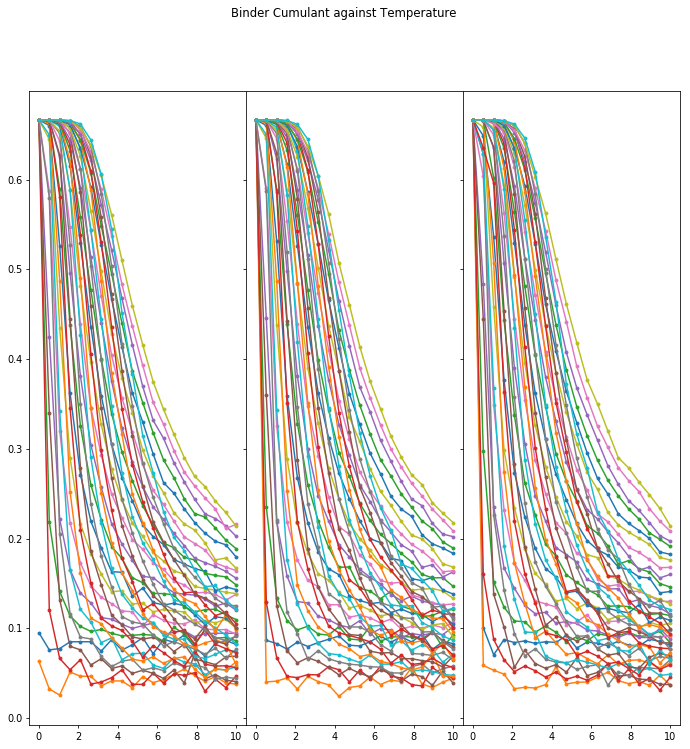

In [7]:
#%%time
from itertools import count
data = np.load('./pickled_data/phase_diagram_3.npz')
locals().update(data)

f, axes = plt.subplots(1,len(Us),figsize = (12,len(Us)*4), sharex = 'col', sharey = 'row', gridspec_kw = dict(hspace = 0, wspace = 0))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for mc_slice1, J in zip(mcmc_binder_cumulants, Js):
    for ax, mc_slice2, U in zip(axes.T, mc_slice1, Us):
        for i, mc_slice3, system_size in zip(count(), mc_slice2, Ns):
            mc_Mf_moments, mc_Mf_central_moments = mc_slice3
            
            def binder_cumulant(central_moments): return 1 - central_moments[4]/(3*central_moments[2]**2)
            
            #ax.scatter(T, binder_cumulant(mc_Mf_central_moments), marker='.')    
            ax.plot(T, binder_cumulant(mc_Mf_central_moments), marker='.')    
            #ax.set(ylim = (0, 0.7))
            
#f.legend(lines, [l.get_label() for l in lines], loc = (0.1,0.93), ncol = len(lines))
f.suptitle('Binder Cumulant against Temperature')

#for ax,U in zip(axes,Us): ax.set(title = f'U = {U}') 
#for ax,J in zip(axes.T, Js): ax.set(ylabel = f'J = {J}') 
#for ax in axes[-1]: ax.set(xlabel = 'T')
f.savefig('./Phase Diagram.png')

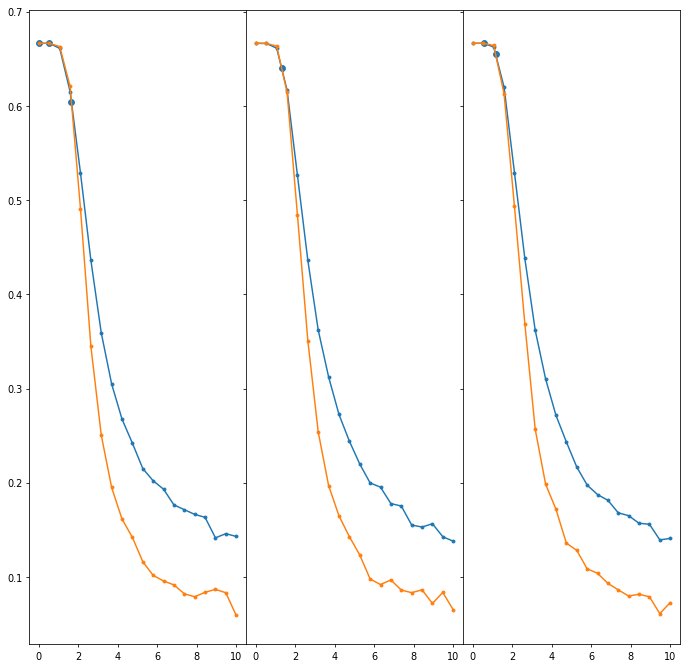

In [8]:
#%%time
from itertools import count
data = np.load('./pickled_data/phase_diagram_3.npz')
locals().update(data)

f, axes = plt.subplots(1,len(Us),figsize = (12,len(Us)*4), sharex = 'col', sharey = 'row', gridspec_kw = dict(hspace = 0, wspace = 0))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def solve(f,x):
    s = np.sign(f)
    z = np.where(s == 0)[0]
    if z.size > 0:
        return z
    else:
        s = s[0:-1] + s[1:]
        z = np.where(s == 0)[0]
        return z

def interp(f,x,z):
    m = (f[z+1] - f[z]) / (x[z+1] - x[z])
    return x[z] - f[z]/m

for i, mc_slice1, J in zip(count(), mcmc_binder_cumulants, Js):
    if i != 10: continue
    for ax, mc_slice2, U in zip(axes.T, mc_slice1, Us):
        
        y = binder_cumulant(mc_slice2[0,1])-binder_cumulant(mc_slice2[1,1])
        x = T
        z = solve(y, x)
        intersection = interp(y,x,z)
        y_val = np.interp(intersection, x, binder_cumulant(mc_slice2[0,1]))
        ax.scatter([intersection,], [y_val,])
        
        for i, mc_slice3, system_size in zip(count(), mc_slice2, Ns):
            mc_Mf_moments, mc_Mf_central_moments = mc_slice3
            
            def binder_cumulant(central_moments): return 1 - central_moments[4]/(3*central_moments[2]**2)
            
            #ax.scatter(T, binder_cumulant(mc_Mf_central_moments), marker='.')    
            ax.plot(T, binder_cumulant(mc_Mf_central_moments), marker='.')    
            #ax.set(ylim = (0, 0.7))
            

N_steps = 40000
N_burn_in = 5000
total_time = 29291.590218305588
(Js, Us, Ns, mc/direct, n_cumulant, beta)
(20, 3, 2, 2, 5, 20)
(Us, mc/direct, n_cumulants, Js, beta)
(3, 2, 5, 20, 20)


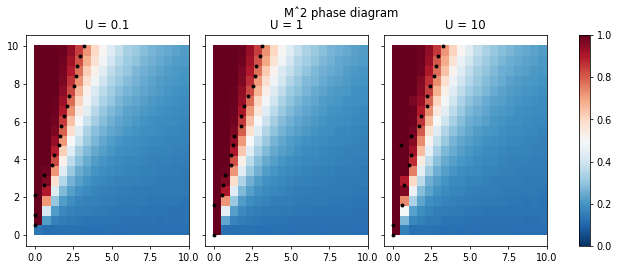

In [9]:
from matplotlib.colors import Normalize
#%%time
def binder_cumulant(central_moments): return 1 - central_moments[4]/(3*central_moments[2]**2)

from itertools import count
data = np.load('./pickled_data/phase_diagram_3.npz')
locals().update(data)

for k,v in data.items():
    if k != 'mcmc_binder_cumulants': print(f'{k} = {v}')

f, axes = plt.subplots(1,len(Us),figsize = (12,4),sharex = 'col', sharey = 'row', gridspec_kw = dict(hspace = 0.1, wspace = 0.1))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

#mcmc_binder_cumulants.shape = (Js, Us, Ns, n_cumulant)
print("(Js, Us, Ns, mc/direct, n_cumulant, beta)")
print(mcmc_binder_cumulants.shape)
i_N = 0
data = np.einsum('jumnb->umnjb', mcmc_binder_cumulants[:, :, i_N])
print("(Us, mc/direct, n_cumulants, Js, beta)")
print(data.shape)


intercept_T = np.zeros(shape = (len(Us), len(Js)))

for i, mc_slice1, J in zip(count(), mcmc_binder_cumulants, Js):
    for j, mc_slice2, U in zip(count(), mc_slice1, Us):
        
        y = binder_cumulant(mc_slice2[0,1])-binder_cumulant(mc_slice2[1,1])
        x = T
        z = solve(y, x)
        intersection = interp(y,x,z)
        y_val = np.interp(intersection, x, binder_cumulant(mc_slice2[0,1]))
        if intersection.size == 0: intersection = [np.nan,]
        
        intercept_T[j,i] = intersection[-1]

for i,ax, U_slice, U in zip(count(), axes, data, Us):
    mc_Mf_moments, mc_Mf_central_moments = U_slice

    #ax.scatter(T, binder_cumulant(mc_Mf_central_moments), marker='.')    
    #ax.plot(T, binder_cumulant(mc_Mf_central_moments), marker='.')   

    norm = Normalize(vmin=0, vmax=1)        
    cs = ax.pcolormesh(Js, T, mc_Mf_central_moments[2], cmap='RdBu_r', norm = norm)
    
    ax.scatter(intercept_T[i,:], Js, color = 'k', marker = '.')
    ax.set(
        title = f'U = {U}',
        #xlim = [0,5],
        #ylim = [0,1],
        #xlabel = 'U',
        #yscale = 'log',
        #xscale = 'log',
    )
    #ax.set(ylim = (0, 0.7))
            
#f.legend(lines, [l.get_label() for l in lines], loc = (0.1,0.93), ncol = len(lines))
f.suptitle('Mˆ2 phase diagram')
f.colorbar(cs, ax=axes, orientation='vertical')

#for ax,U in zip(axes,Us): ax.set(title = f'U = {U}') 
#for ax,J in zip(axes.T, Js): ax.set(ylabel = f'J = {J}') 
#for ax in axes[-1]: ax.set(xlabel = 'T')
f.savefig('./Phase Diagram.png')

N_steps = 40000
N_burn_in = 5000
total_time = 29291.590218305588
(Js, Us, Ns, mc/direct, n_cumulant, beta)
(20, 3, 2, 2, 5, 20)
(Us, mc/direct, n_cumulants, Js, beta)
(3, 2, 5, 20, 20)


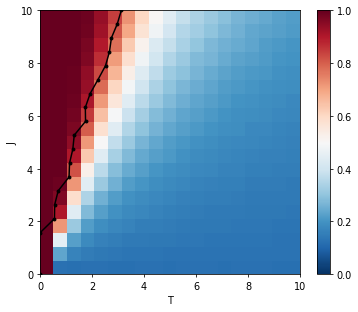

In [20]:
from matplotlib.colors import Normalize
#%%time
def binder_cumulant(central_moments): return 1 - central_moments[4]/(3*central_moments[2]**2)

from itertools import count
data = np.load('./pickled_data/phase_diagram_3.npz')
locals().update(data)

for k,v in data.items():
    if k != 'mcmc_binder_cumulants': print(f'{k} = {v}')

f, ax = plt.subplots(1,1,figsize = (6,5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

#mcmc_binder_cumulants.shape = (Js, Us, Ns, n_cumulant)
print("(Js, Us, Ns, mc/direct, n_cumulant, beta)")
print(mcmc_binder_cumulants.shape)
i_N = 0
data = np.einsum('jumnb->umnjb', mcmc_binder_cumulants[:, :, i_N])
print("(Us, mc/direct, n_cumulants, Js, beta)")
print(data.shape)


intercept_T = np.zeros(shape = (len(Us), len(Js)))

for i, mc_slice1, J in zip(count(), mcmc_binder_cumulants, Js):
    for j, mc_slice2, U in zip(count(), mc_slice1, Us):
        
        y = binder_cumulant(mc_slice2[0,1])-binder_cumulant(mc_slice2[1,1])
        x = T
        z = solve(y, x)
        intersection = interp(y,x,z)
        y_val = np.interp(intersection, x, binder_cumulant(mc_slice2[0,1]))
        if intersection.size == 0: intersection = [np.nan,]
        
        intercept_T[j,i] = intersection[-1]

for i, U_slice, U in zip(count(), data, Us):
    if U != 1: continue
    mc_Mf_moments, mc_Mf_central_moments = U_slice

    #ax.scatter(T, binder_cumulant(mc_Mf_central_moments), marker='.')    
    #ax.plot(T, binder_cumulant(mc_Mf_central_moments), marker='.')   

    norm = Normalize(vmin=0, vmax=1)        
    cs = ax.pcolormesh(Js, T, mc_Mf_central_moments[2], cmap='RdBu_r', norm = norm)
    
    ax.plot(intercept_T[i,:], Js, color = 'k', marker = '.')
    ax.set(
        #title = f'U = {U}',
        #xlim = [0,5],
        #ylim = [0,1],
        xlabel = 'T',
        ylabel = 'J'
        #yscale = 'log',
        #xscale = 'log',
    )
    ax.set(ylim = (0, 10))
            
#f.legend(lines, [l.get_label() for l in lines], loc = (0.1,0.93), ncol = len(lines))
#f.suptitle('Mˆ2 phase diagram')
f.colorbar(cs, ax=ax, orientation='vertical')

#for ax,U in zip(axes,Us): ax.set(title = f'U = {U}') 
#for ax,J in zip(axes.T, Js): ax.set(ylabel = f'J = {J}') 
#for ax in axes[-1]: ax.set(xlabel = 'T')
f.savefig('./figs/Phase_Diagram.pdf')